In [67]:
# Cell 1: Setup & Imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import joblib
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from utils.preprocessing import preprocess_features

model = joblib.load("../model/model/readmission_rf_model.pkl")

In [68]:
# Cell 2: Define Input Widgets
age = widgets.IntSlider(value=65, min=18, max=100, description='Age:')
gender = widgets.Dropdown(options=['Male', 'Female'], description='Gender:')
primary_diagnosis = widgets.Dropdown(
    options=['Heart Disease', 'COPD', 'Diabetes', 'Kidney Disease'],
    description='Diagnosis:'
)
num_procedures = widgets.IntSlider(min=0, max=10, description='Procedures:')
days_in_hospital = widgets.IntSlider(min=1, max=20, description='Days in hospital:')
comorbidity_score = widgets.IntSlider(min=0, max=4, description='Comorbidity:')
discharge_to = widgets.Dropdown(
    options=['Home', 'Home Health Care', 'Rehabilitation Facility', 'Skilled Nursing Facility'],
    description='Discharge:'
)

In [69]:
# Cell 3: Create Predict Button & Output Area
button = widgets.Button(description="Predict Risk")
output = widgets.Output()

In [70]:
# Cell 4: Display Widgets
display(age, gender, primary_diagnosis, num_procedures, days_in_hospital,
        comorbidity_score, discharge_to, button, output)

IntSlider(value=65, description='Age:', min=18)

Dropdown(description='Gender:', options=('Male', 'Female'), value='Male')

Dropdown(description='Diagnosis:', options=('Heart Disease', 'COPD', 'Diabetes', 'Kidney Disease'), value='Hea…

IntSlider(value=0, description='Procedures:', max=10)

IntSlider(value=1, description='Days in hospital:', max=20, min=1)

IntSlider(value=0, description='Comorbidity:', max=4)

Dropdown(description='Discharge:', options=('Home', 'Home Health Care', 'Rehabilitation Facility', 'Skilled Nu…

Button(description='Predict Risk', style=ButtonStyle())

Output()

In [71]:
# Cell 5: Define Callback Function
def predict_callback():
    with output:
        clear_output()
        input_df = pd.DataFrame([{
            'age': age.value,
            'gender': gender.value,
            'primary_diagnosis': primary_diagnosis.value,
            'num_procedures': num_procedures.value,
            'days_in_hospital': days_in_hospital.value,
            'comorbidity_score': comorbidity_score.value,
            'discharge_to': discharge_to.value
        }])

        processed_input = preprocess_features(input_df)
        score = model.predict_proba(processed_input)[:, 1][0]

        if score > 0.85:
            tier = "High"
        elif score > 0.50:
            tier = "Medium"
        else:
            tier = "Low"

        print(f"[✓] Risk Score: {score:.2f}")
        print(f"[✓] Risk Tier: {tier}")

In [72]:
# Cell 6: Bind Callback to Button
button.on_click(predict_callback)

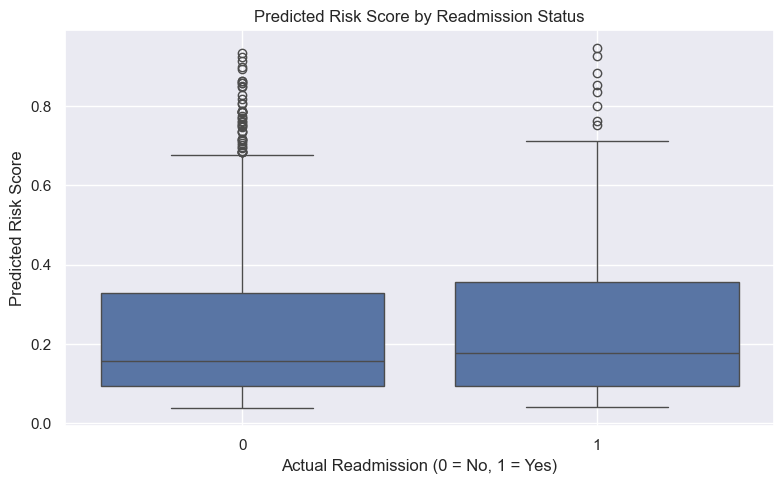

In [63]:
# Cell 7:
# Shows distribution of model scores by actual outcome
df_results = pd.read_csv("../model/output/risk_tiered_predictions.csv")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_results, x='actual_readmission', y='readmission_probability')
plt.title('Predicted Risk Score by Readmission Status')
plt.xlabel('Actual Readmission (0 = No, 1 = Yes)')
plt.ylabel('Predicted Risk Score')
plt.grid(True)
plt.tight_layout()
plt.show()

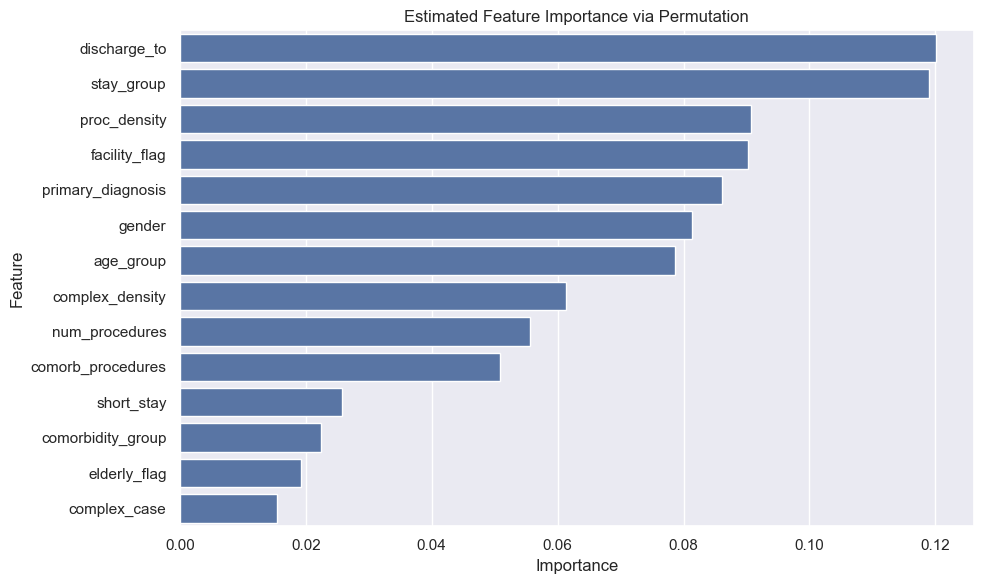

In [64]:
# Cell 8:
# Shows how the model assigns different predicted probabilities to patients based on whether they were actually readmitted.
from sklearn.inspection import permutation_importance

df_raw = pd.read_csv("../data/sample_data.csv")
X_raw = df_raw.drop(columns=["readmitted"])
y_raw = df_raw["readmitted"]
X_processed = preprocess_features(X_raw)
perm = permutation_importance(model, X_processed, y_raw, n_repeats=5, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Estimated Feature Importance via Permutation")
plt.tight_layout()
plt.show()

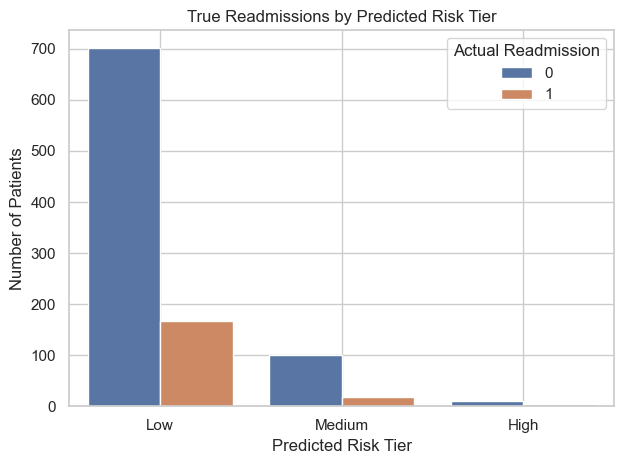

In [65]:
# Cell 9:
# This chart compares the number of patients in each risk tier who were actually readmitted or not.
sns.set_theme(style="whitegrid")
sns.countplot(data=df_results, x='risk_tier', hue='actual_readmission')
plt.title("True Readmissions by Predicted Risk Tier")
plt.xlabel("Predicted Risk Tier")
plt.ylabel("Number of Patients")
plt.legend(title="Actual Readmission")
plt.tight_layout()
plt.grid(True)
plt.show()

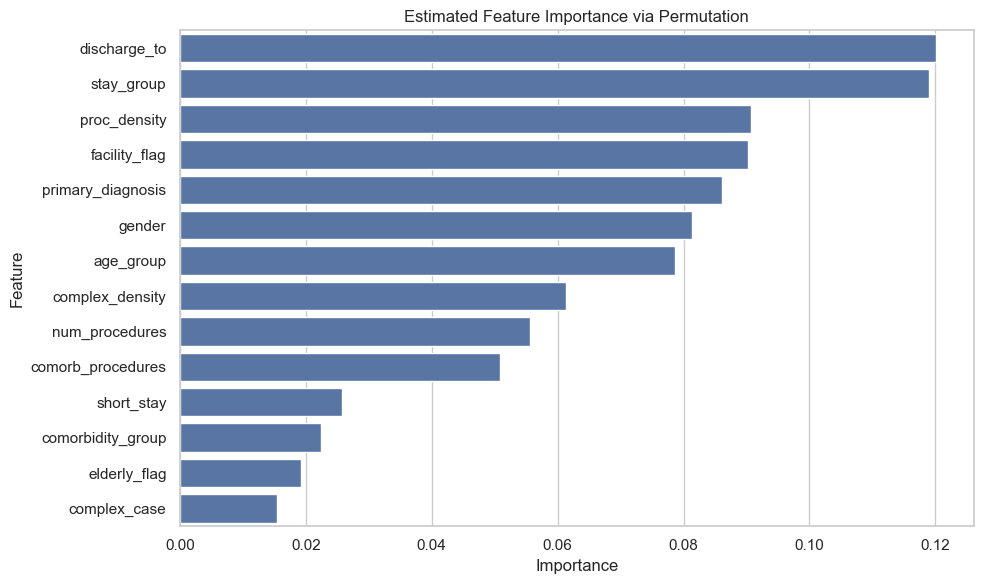

In [66]:
# Cell 8: Estimate feature importance using original test data
from sklearn.inspection import permutation_importance

# Load raw input data (before preprocessing)
df_raw = pd.read_csv("../data/sample_data.csv")

# Extract X and y
X_raw = df_raw.drop(columns=["readmitted"])
y_raw = df_raw["readmitted"]

# Preprocess to match model input
X_processed = preprocess_features(X_raw)

# Calculate permutation importances
perm = permutation_importance(model, X_processed, y_raw, n_repeats=5, random_state=42)

# Format for plotting
importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Estimated Feature Importance via Permutation")
plt.tight_layout()
plt.show()


In [51]:
# Cell 9: Generate test cases to probe model
print("\n=== Synthetic Test Cases ===")
test_cases = pd.DataFrame([
    {'age': 30, 'gender': 'Male', 'primary_diagnosis': 'COPD', 'num_procedures': 0, 'days_in_hospital': 1, 'comorbidity_score': 0, 'discharge_to': 'Home'}, # low risk
    {'age': 85, 'gender': 'Female', 'primary_diagnosis': 'Diabetes', 'num_procedures': 5, 'days_in_hospital': 10, 'comorbidity_score': 4, 'discharge_to': 'Skilled Nursing Facility'}, # high risk
    {'age': 65, 'gender': 'Male', 'primary_diagnosis': 'Heart Disease', 'num_procedures': 0, 'days_in_hospital': 1, 'comorbidity_score': 0, 'discharge_to': 'Home'}, # medium risk
    {'age': 70, 'gender': 'Female', 'primary_diagnosis': 'Kidney Disease', 'num_procedures': 3, 'days_in_hospital': 7, 'comorbidity_score': 2, 'discharge_to': 'Rehabilitation Facility'}, # medium risk
    {'age': 40, 'gender': 'Male', 'primary_diagnosis': 'Heart Disease', 'num_procedures': 1, 'days_in_hospital': 2, 'comorbidity_score': 1, 'discharge_to': 'Home Health Care'}, # low risk
])

processed_cases = preprocess_features(test_cases)
test_scores = model.predict_proba(processed_cases)[:, 1]

for i, score in enumerate(test_scores):
    tier = "High" if score > 0.85 else "Medium" if score > 0.5 else "Low"
    print(f"Case {i+1} → Score: {score:.2f}, Tier: {tier}, Profile: {test_cases.iloc[i].to_dict()}")



=== Synthetic Test Cases ===
Case 1 → Score: 0.35, Tier: Low, Profile: {'age': 30, 'gender': 'Male', 'primary_diagnosis': 'COPD', 'num_procedures': 0, 'days_in_hospital': 1, 'comorbidity_score': 0, 'discharge_to': 'Home'}
Case 2 → Score: 0.45, Tier: Low, Profile: {'age': 85, 'gender': 'Female', 'primary_diagnosis': 'Diabetes', 'num_procedures': 5, 'days_in_hospital': 10, 'comorbidity_score': 4, 'discharge_to': 'Skilled Nursing Facility'}
Case 3 → Score: 0.57, Tier: Medium, Profile: {'age': 65, 'gender': 'Male', 'primary_diagnosis': 'Heart Disease', 'num_procedures': 0, 'days_in_hospital': 1, 'comorbidity_score': 0, 'discharge_to': 'Home'}
Case 4 → Score: 0.59, Tier: Medium, Profile: {'age': 70, 'gender': 'Female', 'primary_diagnosis': 'Kidney Disease', 'num_procedures': 3, 'days_in_hospital': 7, 'comorbidity_score': 2, 'discharge_to': 'Rehabilitation Facility'}
Case 5 → Score: 0.38, Tier: Low, Profile: {'age': 40, 'gender': 'Male', 'primary_diagnosis': 'Heart Disease', 'num_procedures

In [52]:
# 📝 Cell 10: Summary & Reflection
from IPython.display import Markdown

Markdown('''
### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
''')



### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
